In [1]:
import sys
import os
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# import h5py
from torchsummary import summary
from dlsia.core import helpers
from dlsia.core.train_scripts import train_regression, train_segmentation
from dlsia.core.networks import smsnet, baggins, tunet
from dlsia.test_data.two_d import build_test_data, torch_hdf5_loader
from dlsia.viz_tools import plots, draw_sparse_network

import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
# import einops

# import napari


from qlty import qlty2D


import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


This is me cheating and building a raster as we see in the image.
not sure we need it, but I thought I add it in to show how it can be done

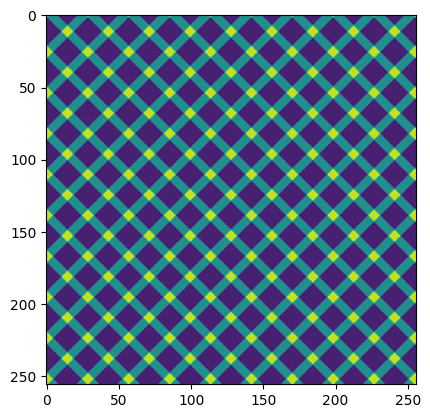

In [2]:
def generate_rotated_heatmap(N, band_width, periodicity, rotation_degrees, shift):
    large_size = int(N * 1.5)  # Make the array large enough to avoid edge effects after rotation
    large_heatmap = np.zeros((large_size, large_size))
    
    for y in range(0, large_size, periodicity):
        start = (y + shift) % large_size
        end = min(start + band_width, large_size)
        large_heatmap[start:end, :] = 1

    rotated_heatmap = rotate(large_heatmap, rotation_degrees, mode='reflect', reshape=False)
    
    crop_x1 = (large_size - N) // 2
    crop_x2 = crop_x1 + N
    crop_y1 = (large_size - N) // 2
    crop_y2 = crop_y1 + N
    
    final_heatmap = rotated_heatmap[crop_y1:crop_y2, crop_x1:crop_x2]
    return final_heatmap


# optically decent values
bands = 0.5*generate_rotated_heatmap(256, 6, 20, 45,7)+0.5*generate_rotated_heatmap(256, 6, 20, -45, 7)
plt.imshow(bands)
plt.show()

In [3]:
dataX = []
dataY = []

for f in sorted(os.listdir("SimARPESForPeter\\SimARPESForPeter\\data_X\\")):
    if 'txt' in f:
        tmp = np.loadtxt("SimARPESForPeter\\SimARPESForPeter\\data_X\\"+f)
        # add the raster as part of the observed data in an added channel
        dataX.append( np.array([tmp, bands]) ) 
        
for f in sorted(os.listdir("SimARPESForPeter\\SimARPESForPeter\\target_Y\\")):
    if 'txt' in f:
        tmp = np.loadtxt("SimARPESForPeter\\SimARPESForPeter\\target_Y\\"+f)
        tmp = ndimage.gaussian_filter(tmp, sigma=1)
        dataY.append(tmp/np.max(tmp))
        
dataX = np.array(dataX)
dataY = np.array(dataY)

In [4]:
print(dataX.shape, dataY.shape)

(10, 2, 256, 256) (10, 256, 256)


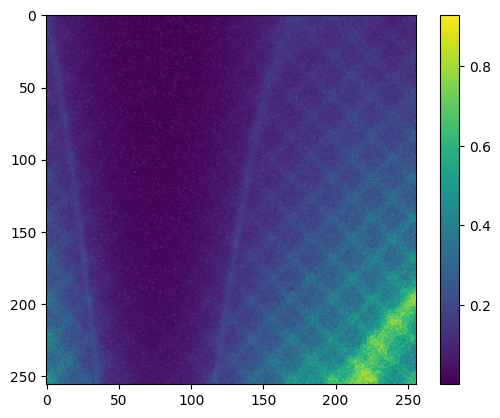

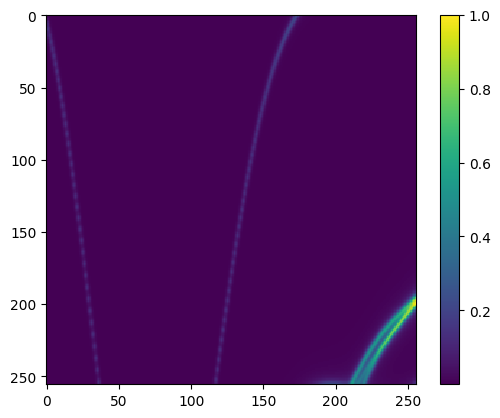

In [5]:
plt.imshow(dataX[0,0])
plt.colorbar()
plt.show()

plt.imshow(dataY[0], interpolation='None')
plt.colorbar()
plt.show()

# napari is nice
#v = napari.view_image(dataY)
#_ = v.add_image(dataX)


In [6]:
GT = torch.Tensor(np.array(dataY)).unsqueeze(1)
OBS = torch.Tensor(np.array(dataX))

print(GT.shape, OBS.shape)

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])


Here we patch it up. I have an RTX3090, so not a whole lot of memory.
Also, by having sliding windows, we essentially augment our data.

In [7]:
qlty_obj = qlty2D.NCYXQuilt(Y=256,X=256,window=(128,128), step=(32,32), border=None, border_weight=0)

In [8]:
# we unstich into pacthes
qGT,qOBS = qlty_obj.unstitch_data_pair(GT,OBS)
print(qGT.shape,qOBS.shape)

torch.Size([250, 1, 128, 128]) torch.Size([250, 2, 128, 128])


In [9]:
train_slice = slice(0,qGT.shape[0],2)
test_slice = slice(1,qGT.shape[0],2)
train_data = TensorDataset(qOBS[train_slice], qGT[train_slice])
validation_data = TensorDataset(qOBS[test_slice], qGT[test_slice])

#train_data = TensorDataset(GT,MSK)
#validation_data = TensorDataset(GT,MSK)

batch_size=16
num_workers=0

loader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
train_loader = DataLoader(train_data, **loader_params)
loader_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_workers}
validation_loader = DataLoader(validation_data, **loader_params)

Network 1


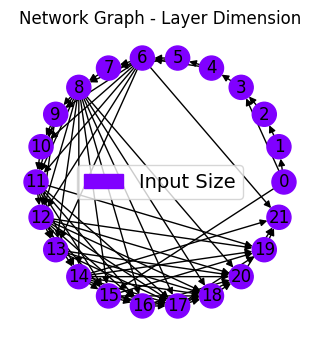

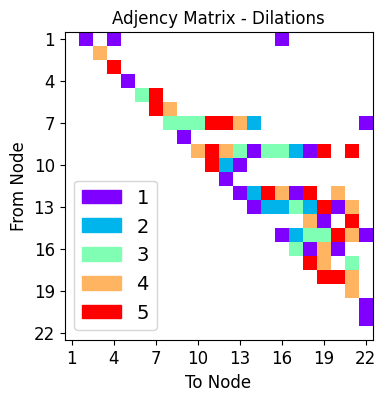

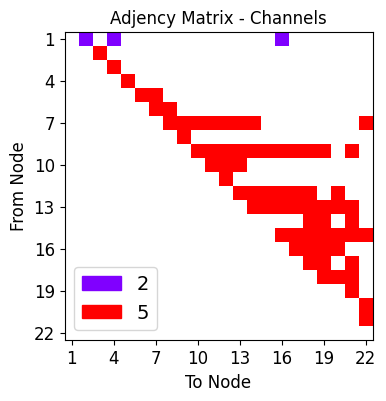

Network 2


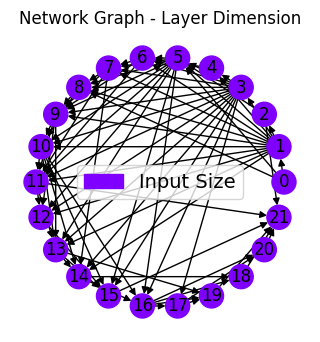

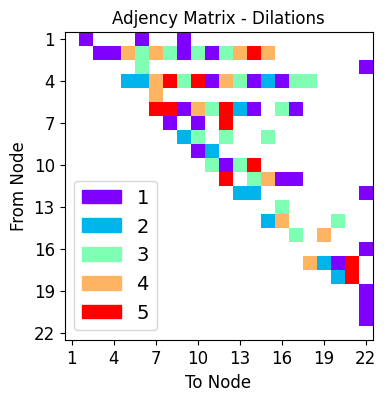

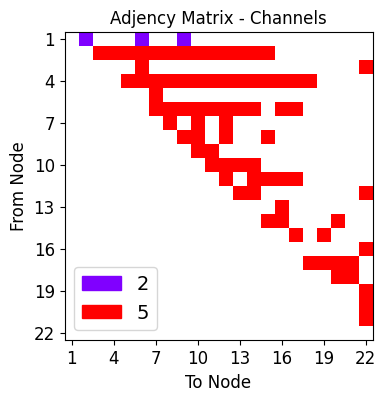

Network 3


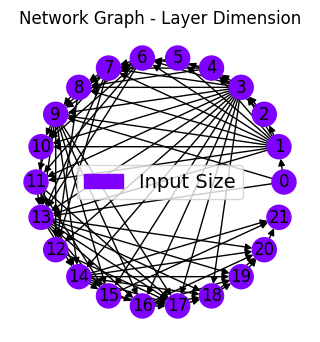

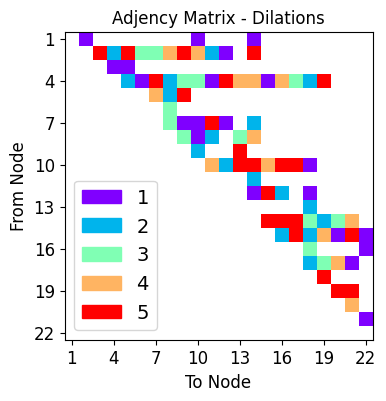

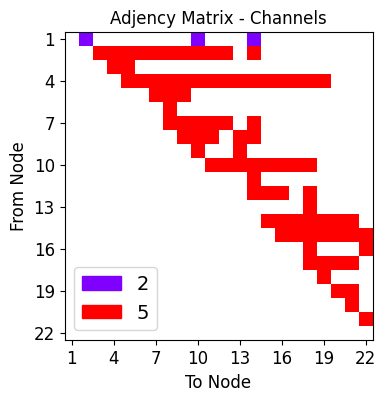

Network 4


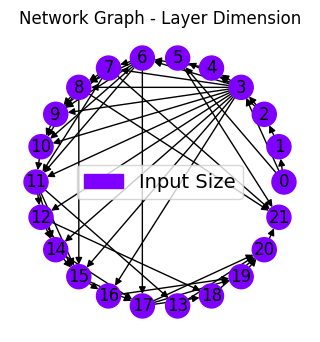

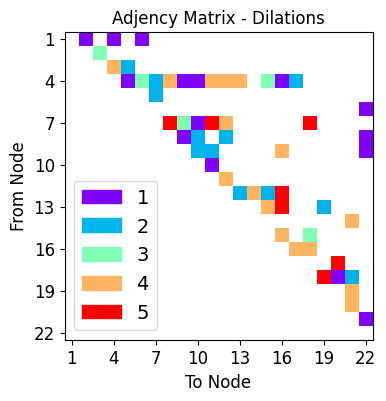

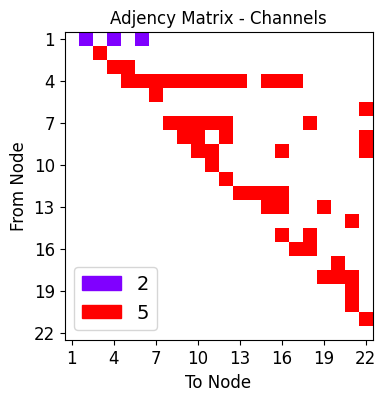

Network 5


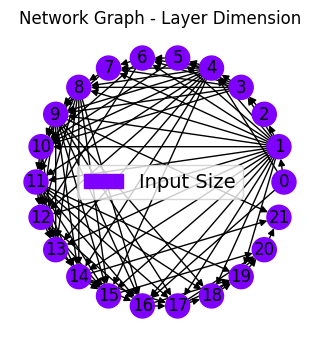

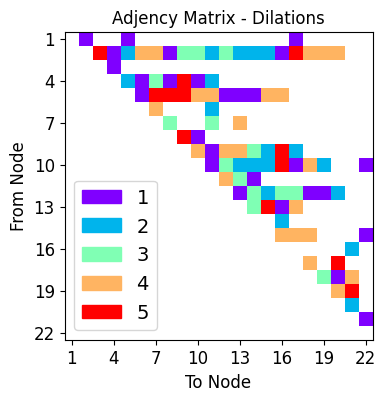

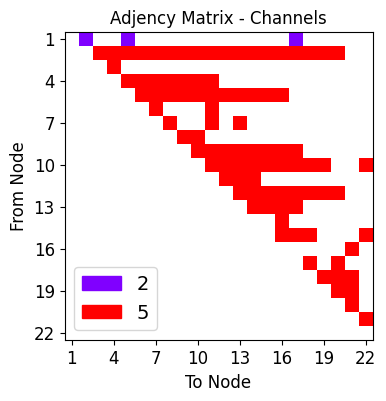

In [10]:
# SMSNet parameters
in_channels = 2 
out_channels = 1 
num_layers = 20

# When alpha > 0, short-range skip connections are favoured
alpha = 0.75

# When gamma is 0, the degree of each node is chosen uniformly between 0 and max_k
# specifically, P(degree) \propto degree^-gamma
gamma = 0.75

# we can limit the maximum and minimum degree of our graph 
max_k = num_layers
min_k = 1

# features channel posibilities per edge
hidden_out_channels = [5] 

# possible dilation choices
dilation_choices = [1,2,3,4,5] 

# Here are some parameters that define how networks are drawn at random
# the layer probabilities dictionairy define connections
layer_probabilities={'LL_alpha': alpha,
                     'LL_gamma': gamma,
                     'LL_max_degree':max_k,
                     'LL_min_degree':min_k,
                     'IL': 0.1,
                     'LO': 0.1,
                     'IO': False}

# if desired, one can introduce scale changes (down and upsample)
# a not-so-thorough look indicates that this isn't really super beneficial
# in the model systems we looked at
sizing_settings = {'stride_base':2, #better keep this at 2
                   'min_power': 0,
                   'max_power': 0}

# defines the type of network we want to build

network_type = "Regression"

nets = [] 
n_networks = 5
epochs = 100     # Set number of epochs
criterion = nn.L1Loss()   # For segmenting 
learning_rate = 1e-2

for ii in range(n_networks):
    torch.cuda.empty_cache()
    print("Network %i"%(ii+1))
    smsnet_model = smsnet.random_SMS_network(in_channels=in_channels,
                                             out_channels=out_channels,
                                             in_shape=(32,32),
                                             out_shape=(32,32),
                                             sizing_settings=sizing_settings,
                                             layers=num_layers,
                                             dilation_choices=dilation_choices,
                                             hidden_out_channels=hidden_out_channels,
                                             layer_probabilities=layer_probabilities,
                                             network_type=network_type
                                            )
    
    # lets plot the network
    net_plot,dil_plot,chan_plot = draw_sparse_network.draw_network(smsnet_model)
    plt.show()

    nets.append(smsnet_model)
    

Start training
Total number of refineable parameters:  47537
Using device: cuda:0
Epoch 5 of 100 | Learning rate 1.000e-02
Training Loss: 2.2129e-02 | Validation Loss: 2.1030e-02
Training CC: 0.7160   Validation CC  : 0.7556 
Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.8148e-02 | Validation Loss: 1.8212e-02
Training CC: 0.7707   Validation CC  : 0.7837 
Epoch 15 of 100 | Learning rate 1.000e-02
Training Loss: 1.9362e-02 | Validation Loss: 1.9870e-02
Training CC: 0.7749   Validation CC  : 0.7828 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 1.8282e-02 | Validation Loss: 1.6373e-02
Training CC: 0.7885   Validation CC  : 0.8007 
Epoch 25 of 100 | Learning rate 1.000e-02
Training Loss: 1.5243e-02 | Validation Loss: 1.7873e-02
Training CC: 0.8151   Validation CC  : 0.8283 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 1.7628e-02 | Validation Loss: 2.1747e-02
Training CC: 0.8218   Validation CC  : 0.8279 
Epoch 35 of 100 | Learning rate 1.000e-02
Trainin

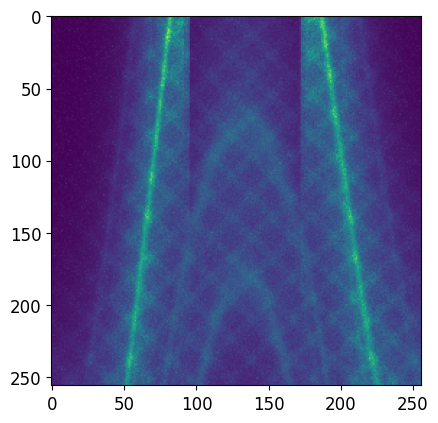

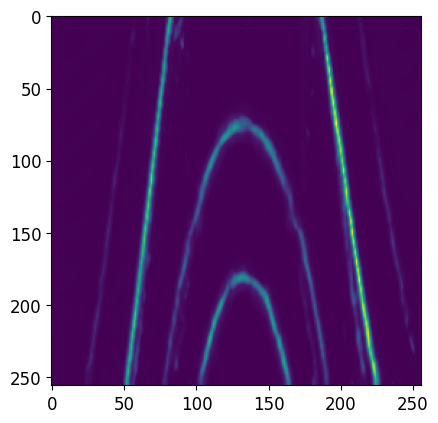

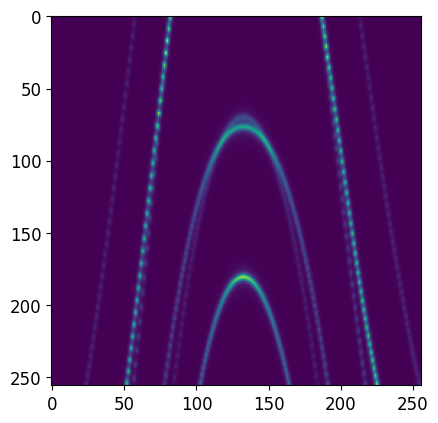

Start training
Total number of refineable parameters:  48747
Using device: cuda:0
Epoch 5 of 100 | Learning rate 1.000e-02
Training Loss: 1.9331e-02 | Validation Loss: 1.7464e-02
Training CC: 0.7838   Validation CC  : 0.8229 
Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.7090e-02 | Validation Loss: 1.4832e-02
Training CC: 0.8255   Validation CC  : 0.8485 
Epoch 15 of 100 | Learning rate 1.000e-02
Training Loss: 1.6795e-02 | Validation Loss: 1.8061e-02
Training CC: 0.8354   Validation CC  : 0.8527 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 1.6224e-02 | Validation Loss: 1.8337e-02
Training CC: 0.8707   Validation CC  : 0.8641 
Epoch 25 of 100 | Learning rate 1.000e-02
Training Loss: 1.6750e-02 | Validation Loss: 1.7370e-02
Training CC: 0.8728   Validation CC  : 0.8722 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 1.2703e-02 | Validation Loss: 1.6982e-02
Training CC: 0.8958   Validation CC  : 0.8939 
Epoch 35 of 100 | Learning rate 1.000e-02
Trainin

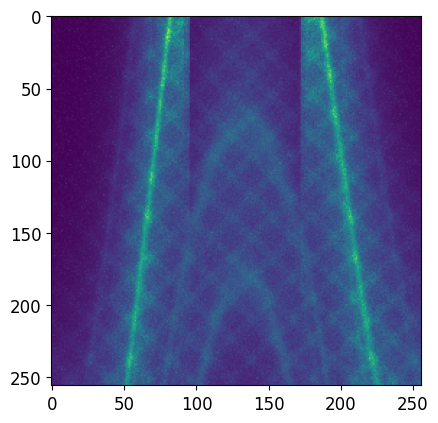

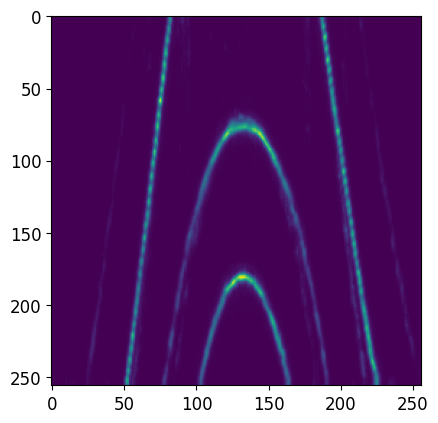

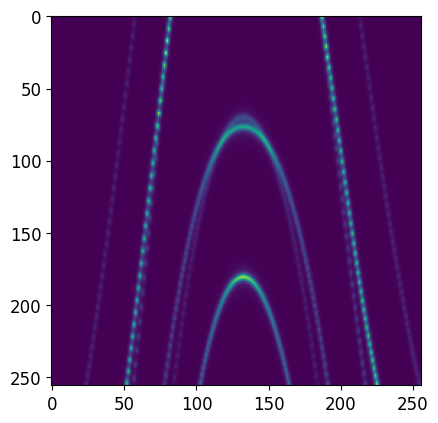

Start training
Total number of refineable parameters:  66372
Using device: cuda:0
Epoch 5 of 100 | Learning rate 1.000e-02
Training Loss: 1.8434e-02 | Validation Loss: 1.7549e-02
Training CC: 0.7793   Validation CC  : 0.7797 
Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.8884e-02 | Validation Loss: 1.7956e-02
Training CC: 0.8004   Validation CC  : 0.8077 
Epoch 15 of 100 | Learning rate 1.000e-02
Training Loss: 1.9070e-02 | Validation Loss: 1.4400e-02
Training CC: 0.8443   Validation CC  : 0.8559 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 1.4110e-02 | Validation Loss: 1.8340e-02
Training CC: 0.8805   Validation CC  : 0.8878 
Epoch 25 of 100 | Learning rate 1.000e-02
Training Loss: 1.6536e-02 | Validation Loss: 1.5948e-02
Training CC: 0.8912   Validation CC  : 0.8505 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 1.4849e-02 | Validation Loss: 1.5535e-02
Training CC: 0.8990   Validation CC  : 0.8874 
Epoch 35 of 100 | Learning rate 1.000e-02
Trainin

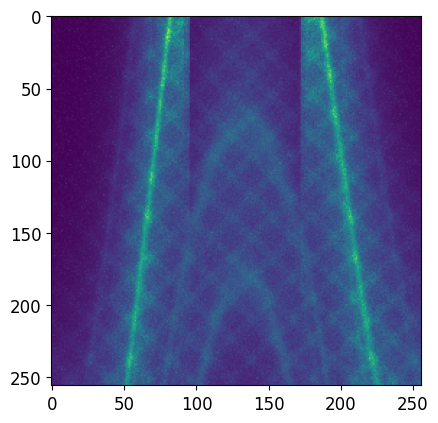

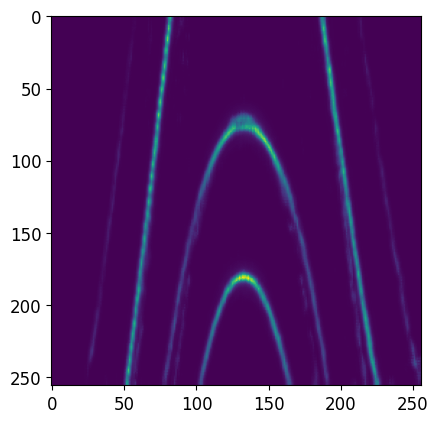

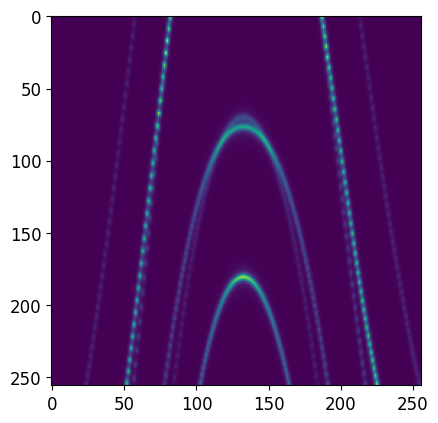

Start training
Total number of refineable parameters:  25922
Using device: cuda:0
Epoch 5 of 100 | Learning rate 1.000e-02
Training Loss: 1.9683e-02 | Validation Loss: 2.3723e-02
Training CC: 0.7419   Validation CC  : 0.7605 
Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.9951e-02 | Validation Loss: 2.7896e-02
Training CC: 0.7650   Validation CC  : 0.7367 
Epoch 15 of 100 | Learning rate 1.000e-02
Training Loss: 1.8781e-02 | Validation Loss: 1.9863e-02
Training CC: 0.7616   Validation CC  : 0.7747 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 1.7358e-02 | Validation Loss: 1.8977e-02
Training CC: 0.7926   Validation CC  : 0.7947 
Epoch 25 of 100 | Learning rate 1.000e-02
Training Loss: 2.0227e-02 | Validation Loss: 1.8008e-02
Training CC: 0.7936   Validation CC  : 0.7783 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 1.5439e-02 | Validation Loss: 1.8412e-02
Training CC: 0.8089   Validation CC  : 0.7776 
Epoch 35 of 100 | Learning rate 1.000e-02
Trainin

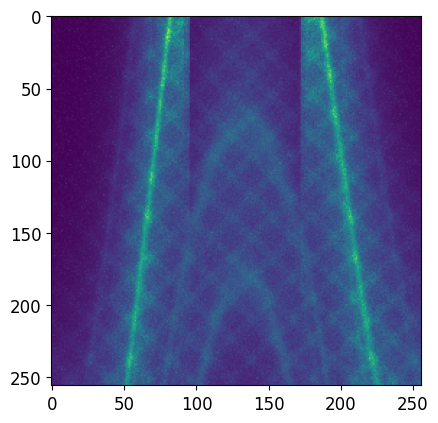

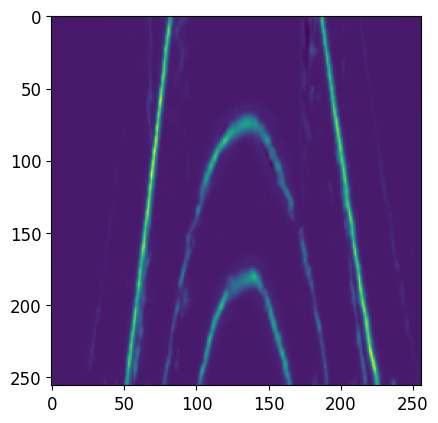

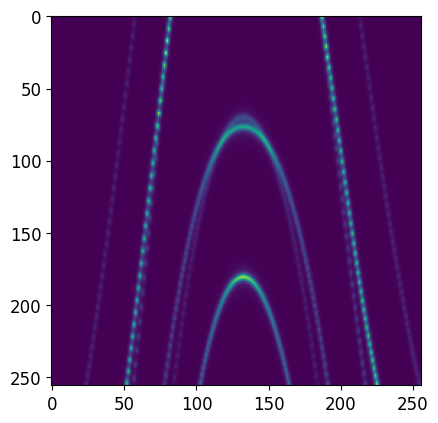

Start training
Total number of refineable parameters:  72592
Using device: cuda:0
Epoch 5 of 100 | Learning rate 1.000e-02
Training Loss: 1.7848e-02 | Validation Loss: 2.0920e-02
Training CC: 0.7696   Validation CC  : 0.7728 
Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.9360e-02 | Validation Loss: 2.2621e-02
Training CC: 0.7844   Validation CC  : 0.8298 
Epoch 15 of 100 | Learning rate 1.000e-02
Training Loss: 1.5944e-02 | Validation Loss: 1.4766e-02
Training CC: 0.8305   Validation CC  : 0.8576 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 1.5714e-02 | Validation Loss: 1.7053e-02
Training CC: 0.8634   Validation CC  : 0.8629 
Epoch 25 of 100 | Learning rate 1.000e-02
Training Loss: 1.2890e-02 | Validation Loss: 1.2525e-02
Training CC: 0.8771   Validation CC  : 0.8822 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 1.5418e-02 | Validation Loss: 1.4215e-02
Training CC: 0.8833   Validation CC  : 0.8658 
Epoch 35 of 100 | Learning rate 1.000e-02
Trainin

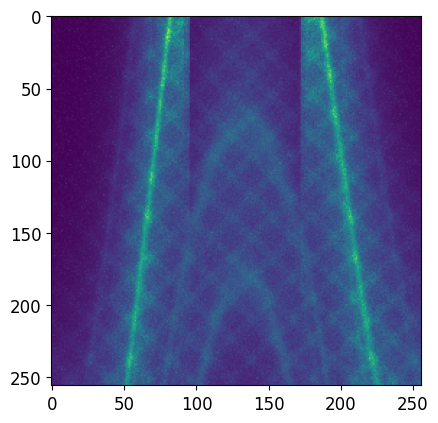

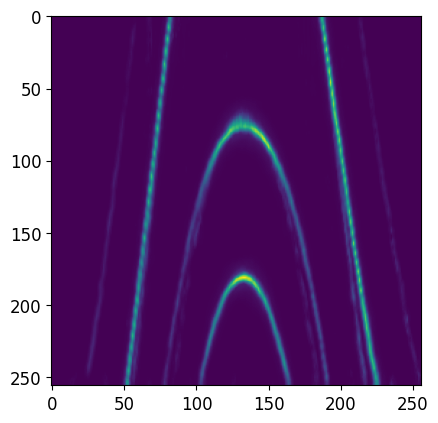

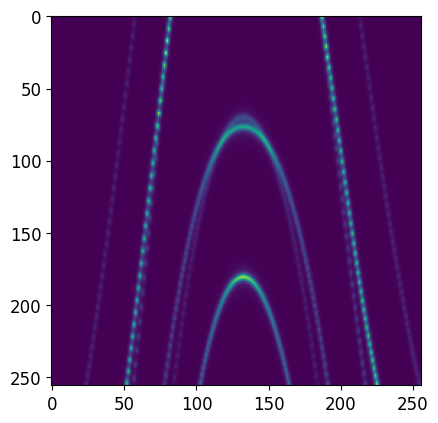

In [15]:
for net in nets:
    print("Start training")
    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print("Total number of refineable parameters: ", pytorch_total_params)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)  # Defined in loop, one per network    
    device = helpers.get_device()
    print(f'Using device: {device}')
    net = net.to(device)
    tmp = train_regression(net,
                           train_loader,
                           validation_loader,
                           epochs,
                           criterion,
                           optimizer,
                           device,
                           show=5,
                           use_amp=True)    
    smsnet_model = net.cpu()
    plots.plot_training_results_regression(tmp[1]).show()
    #plots.plot_training_results_segmentation(tmp[1]).show()
    
    with torch.no_grad():
        tmp_tmp = net(OBS[-1:,...]).cpu()
        
        plt.imshow(np.exp(OBS[-1:,0,...].numpy()[0]))
        plt.show()
        
        plt.imshow(np.exp(tmp_tmp[0,0].numpy()))
        plt.show()
        
        plt.imshow(np.exp(GT[-1:,0,...].numpy()[0]))
        plt.show()
        
    
    
    

In [16]:
bilbo = baggins.model_baggin(nets, model_type="regression", returns_normalized=False, )

In [17]:
m,s = bilbo(OBS[-5:,...], return_std=True)

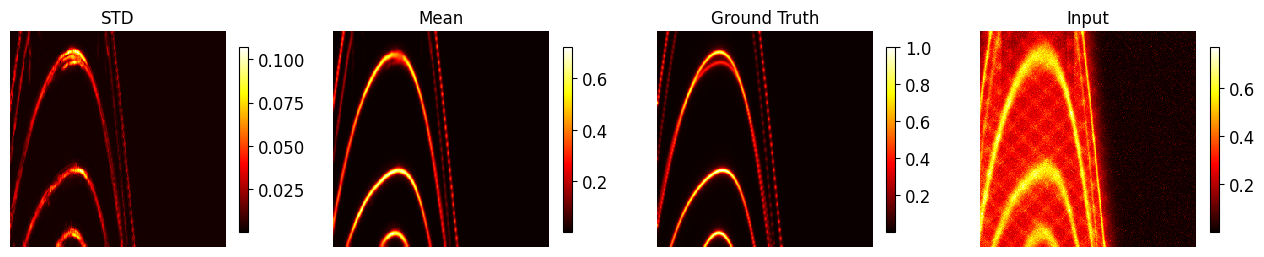

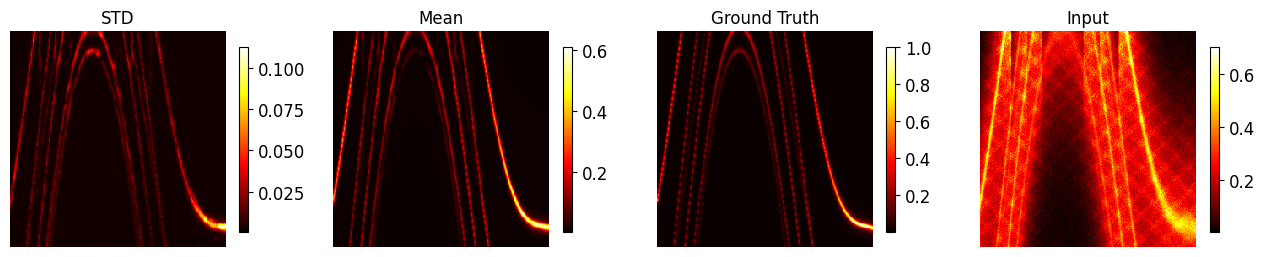

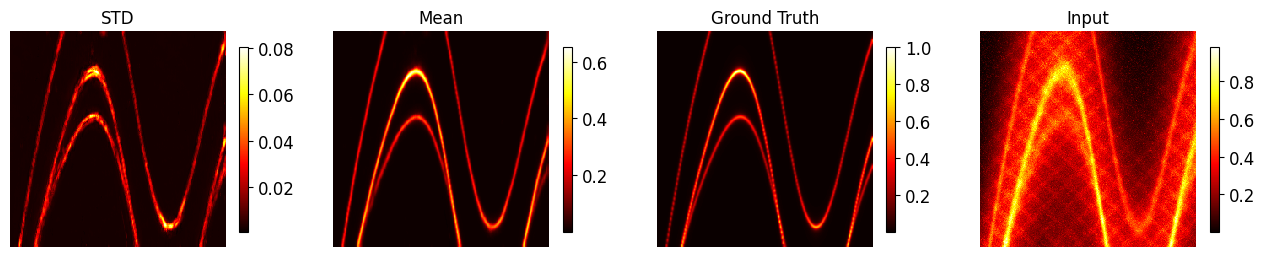

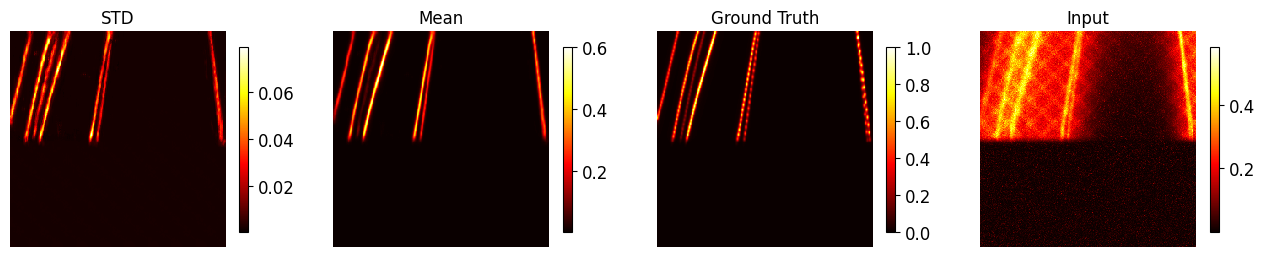

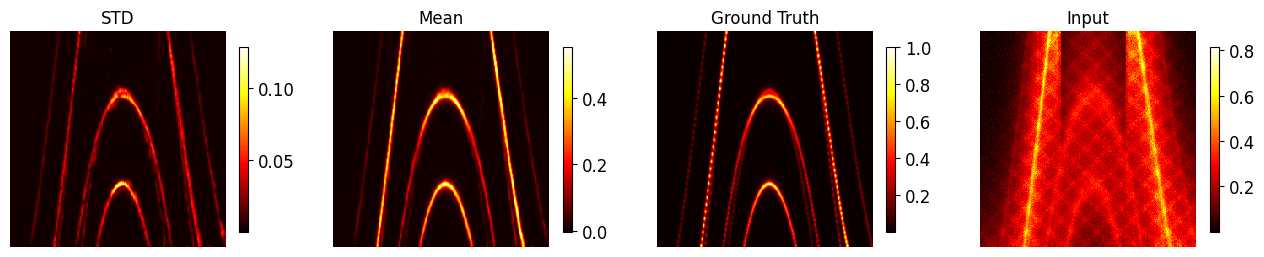

In [18]:
for ii in range(5):
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Plot the heatmaps
    axs[1].imshow(m[ii,0], cmap='hot', interpolation='none')
    axs[1].set_title('Mean')
    axs[1].axis('off')

    axs[0].imshow(s[ii,0], cmap='hot', interpolation='none')
    axs[0].set_title('STD')
    axs[0].axis('off')

    axs[2].imshow(GT[-5+ii,0,...], cmap='hot', interpolation='none')
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')

    axs[3].imshow(OBS[-5+ii,0,...], cmap='hot', interpolation='none')
    axs[3].set_title('Input')
    axs[3].axis('off')

    # Show colorbars for each subplot
    for ax in axs:
        plt.colorbar(mappable=ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.6)

    # Show the plots
    plt.show()
    
    
    print()